In [1]:
import os, time
import numpy as np
import pickle
import torch
from sklearn.decomposition import PCA

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import lines
from helpers import add_inset_axes, Arrow3D

# Shared parameters accross simulations (to be checked at loading)
dim_hid = 512
n_steps = 1000
n_t_ev = 315
n_ifn = 4
z_hat = 1
n_rec_steps = n_steps
n_comp = 3

In [2]:
# Function for loading scenarios. Is reused below for other regimes
def load_res(scenarios):
    n_sce = len(scenarios)
    g_sce = np.zeros((n_sce))
    out_scale_sce = np.zeros((n_sce), dtype=object)
    output_sce = np.zeros((n_sce, n_ifn, n_t_ev))
    hids_sce = np.zeros((n_sce, n_ifn, n_t_ev, dim_hid))
    w_out_sce = np.zeros((n_sce, dim_hid))
    task_sce = np.zeros(n_sce, dtype=object)
    loss_sce = np.zeros((n_sce, n_steps))
    loss_nn_sce =np.zeros((n_sce, n_rec_steps))
    dw_rec_norm_sce = np.zeros((n_sce, n_rec_steps))
    ews_sce = np.zeros((n_sce, 3, dim_hid), dtype=complex)
    h_proj_out_sce = np.zeros((n_sce, n_ifn, n_t_ev, n_comp))
    wo_proj_out_sce = np.zeros((n_sce, n_comp))


    # Load data
    for i_sce in range(n_sce):
        scenario = scenarios[i_sce]
        file_name = "simple_sine_example_%s_n_%d.pkl" % (scenario, dim_hid)
        data_file = os.path.join(data_path, file_name)
        with open(data_file, 'rb') as handle:
            res = pickle.load(handle)
        print('Loaded from ', data_file)
        [
            n_samples, dim_hid_, dim_in, dim_out, n_layers, bias, train_in, train_hid, train_out, train_layers, 
            nonlin, gaussian_init, dt, rec_step_dt, mask_step_dt, task_params, h_0_std, g, out_scale, 
            noise_input_std, noise_init_std, noise_hid_std, n_steps_, lr0, opt_gen, n_mi, 
            task_params_ev, task_ev, n_t_ev_, n_if, n_ifn_, steps, loss_all, output_all, hids_all, h_0_all, 
            sd_if_all, record_train, n_rec_steps_, rec_step_width, rec_steps, loss_nn,
            dw_out_norm_all, dw_rec_norm_all, h_norm_all, dh_norm_all, corr_w_h_all, corr_w_dh_all, 
        ] = res
        del res

        assert dim_hid == dim_hid_
        assert n_steps == n_steps_
        assert n_t_ev == n_t_ev_
        assert n_ifn == n_ifn_
        assert z_hat == task_params["target_amp"]
        assert n_rec_steps == n_rec_steps_

        i_s = 0
        g_sce[i_sce] = g 
        out_scale_sce[i_sce] = out_scale
        output_sce[i_sce] = output_all[:, i_s, 0, :, 0].numpy()
        hids_sce[i_sce] = hids_all[:, i_s, 0, :, :].numpy()
        w_out_sce[i_sce] = sd_if_all[1, i_s]["decoder.weight"][0].numpy()
        task_sce[i_sce] = task_ev
        loss_sce[i_sce] = loss_all[i_s].numpy()
        loss_nn_sce[i_sce] = loss_nn[i_s].numpy()
        dw_rec_norm_sce[i_sce] = dw_rec_norm_all[i_s].numpy()


        # EV of recurrent weight matrix
        key = "rnn.weight_hh_l0"
        w_rec_init = sd_if_all[0][i_s][key]
        w_rec_final = sd_if_all[1][i_s][key]
        dw_rec = w_rec_final - w_rec_init
        ws = [w_rec_init, w_rec_final, dw_rec]
        for i, wi in enumerate(ws):
            ew = torch.linalg.eigvals(wi).cpu().numpy()
            ews_sce[i_sce][i] = ew
            
        # First PC and projection on 1st output vector
        t_pc_min = 0
        n_t_pc_min = int(t_pc_min / (dt * rec_step_dt))
        n_t_pc = n_t_ev - n_t_pc_min
        i_b = 0
        # Compute projection axes: v_0, and the first 2 PCs of h_final outside v_0
        hids = hids_sce[i_sce]
        w_out = w_out_sce[i_sce]
        # 1. First 2 PCs.
        i_ifn = 1
        h = hids[i_ifn, n_t_pc_min:].reshape(n_t_pc, dim_hid)
        pca = PCA(n_comp-1)
        pca.fit(h)
        # 2. Activity on the first output vector - PC1
        pcs = np.linalg.qr(np.r_[pca.components_, w_out[None, :]].T)[0].T
        assert np.allclose(pcs @ pcs.T, np.eye(n_comp), atol=1e-5)
        # Set signs
        for i_out in range(len(pcs)):
            if w_out @ pcs[i_out] < 0:
                pcs[i_out] *= -1
        h_proj_out_sce[i_sce] = hids @ pcs.T
        wo_proj_out_sce[i_sce] = w_out @ pcs.T
            

    res = [g_sce, out_scale_sce, output_sce, hids_sce, w_out_sce, task_sce, loss_sce, loss_nn_sce, dw_rec_norm_sce, ews_sce, 
           h_proj_out_sce, wo_proj_out_sce,
          ]
    return res

In [3]:
scenarios = ["aligned", "marginal", "lazy", "oblique"]
n_sce = len(scenarios)
res = load_res(scenarios)
[g_sce, out_scale_sce, output_sce, hids_sce, w_out_sce, task_sce, loss_sce, loss_nn_sce, dw_rec_norm_sce, ews_sce,
 h_proj_out_sce, wo_proj_out_sce,
] = res 


Loaded from  ../data/simple_sine_example_aligned_n_512.pkl
Loaded from  ../data/simple_sine_example_marginal_n_512.pkl
Loaded from  ../data/simple_sine_example_lazy_n_512.pkl
Loaded from  ../data/simple_sine_example_oblique_n_512.pkl


Save figure to ../figures/fig_9_sine_overview.both


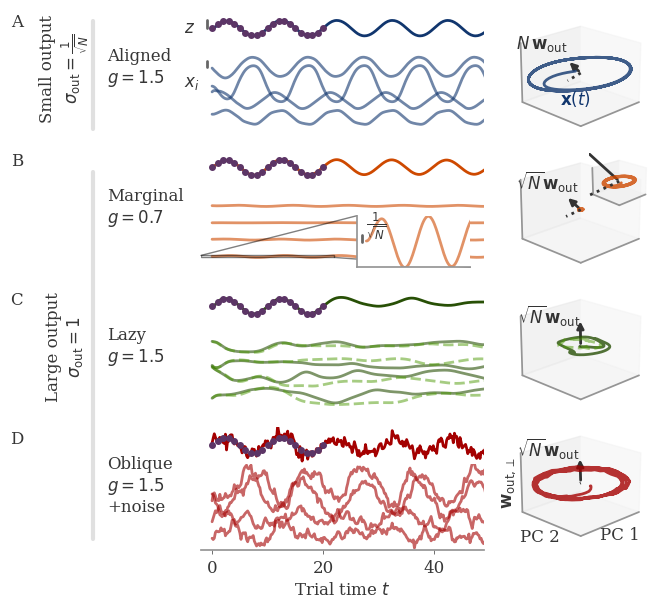

In [20]:
# Summary figure
n_rows = n_sce
n_cols = 1
plt_if = [1]

fig_width = 4.5
fig_height = 1.35 * n_rows
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')#, constrained_layout=True)

# Output
dy_sce = 0.03
bts = np.linspace(0, 1-(dy_sce*(n_rows-1)), n_rows+1)
bots = (bts[:-1] + np.arange(n_rows) * dy_sce)[::-1]
tops = (1 - bots)[::-1]
axes_out = np.zeros((n_rows, n_cols), dtype=object)
axes_hid = np.zeros((n_rows, n_cols), dtype=object)
for i_r in range(n_rows):
    ohf = 0.7
    doh = tops[i_r] - bots[i_r]
    gs0 = GridSpec(1, n_cols)
    gs0.update(left=0., right=0.63, bottom=bots[i_r] + doh*ohf, top=tops[i_r])
    axes_out[i_r] = [plt.subplot(gs0[0, j]) for j in range(n_cols)]
    gs0 = GridSpec(1, n_cols)
    gs0.update(left=0., right=0.63, bottom=bots[i_r], top=tops[i_r]-doh*(1-ohf))
    axes_hid[i_r] = [plt.subplot(gs0[0, j]) for j in range(n_cols)] 

# PCA
gs0 = GridSpec(n_rows, 1)
gs0.update(left=0.68, right=1.0, bottom=0.0, top=1., wspace=0., hspace=0.05)
axes_pca = np.array([[fig.add_subplot(gs0[k, j], projection='3d')
                      for j in range(1)] for k in range(n_rows)])

for i_r in range(n_rows):
    i_sce = i_r
    scenario = scenarios[i_sce]
    lss = ['--', '-']
    alphas = [1., 1.]
    cs_if = cs[i_sce][[1, 0]]
    g = g_sce[i_sce]
    task_ev = task_sce[i_sce]
    ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = task_ev
    i_b = 0
    
    ##############################################################################
    # Output and target
    ax = axes_out[i_r, 0]
    for i_ifn in plt_if:
        output = output_sce[i_sce][i_ifn]
        lbl = ["Init", "Final"][i_ifn]
        ax.plot(ts_ev, output, lss[i_ifn], lw=2, c=cs_if[i_ifn], alpha=alphas[i_ifn], label=lbl)
    m = mask_ev[i_b, :, 0]
    ax.plot(ts_ev[m], target_ev[i_b, :, 0][m], 'o', ms=4, c=colors[4], alpha=1.)
    ylim = z_hat * 2.4
    ax.set_ylim(-ylim, ylim)
    if i_r == 0:
        # Plot scale
        ax.plot([-1]*2, [0, 1], '-', lw=2, c='0.4')
    
    ##############################################################################
    # Hidden states
    alpha = 0.6
    max_h_show = 4
    ax = axes_hid[i_r, 0]
    for i_h in range(max_h_show):
        dy = 3
        offset = dy * i_h
        for i_ifn in plt_if:
            h = hids_sce[i_sce][i_ifn][:, i_h]
            ax.plot(ts_ev, h + offset, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
        if scenario == 'lazy':
            # Plot initial dynamics
            i_ifn = 0
            h = hids_sce[i_sce][i_ifn][:, i_h]
            ax.plot(ts_ev, h + offset, lss[i_ifn], c=cs_if[i_ifn], alpha=0.5)
    if i_r == 0:
        # Plot scale
        ax.plot([-1]*2, np.array([0, 1])+ (max_h_show-1)*dy, '-', lw=2, c='0.4')
    # Insets
    if scenario == 'marginal':
        axins = ax.inset_axes([0.55, 0.05, 0.4, 0.6])
        # x1, x2, y1, y2 = -2, 22, -0.3, 0.3
        ymax_ins = 4/np.sqrt(dim_hid)
        x1, x2, y1, y2 = -2, 22, -ymax_ins, ymax_ins
        i_h = 0 
        for i_ifn in plt_if:
            ls = ['--', '-'][i_ifn]
            h = hids_sce[i_sce][i_ifn][:, i_h]
            axins.plot(ts_ev, h, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.set_yticklabels('')
        axins.set_xticklabels('')
        axins.set_xticks([])
        axins.set_yticks([])
        ax.indicate_inset_zoom(axins, edgecolor="black")
        # Plot scale
        y = 1/np.sqrt(dim_hid)
        axins.plot([-1]*2, [0, y], '-', lw=2, c='0.4')
        axins.text(0, 0, r"$\frac{1}{\sqrt{N}}$", ha='left', va='bottom')
    # yticks
    ymax = (max_h_show-1) * dy
    ax.set_ylim(-0.3 * ymax, 1.4 * ymax)

    ##############################################################################
    # PCA
    alpha = 0.8
    ax = axes_pca[i_r, 0]
    h_proj_plt = h_proj_out_sce
    for i_ifn in plt_if:
        h_proj = h_proj_plt[i_sce, i_ifn]
        ax.plot(*h_proj.T, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
    if scenario == 'lazy':
        i_ifn = 0
        h_proj = h_proj_plt[i_sce, i_ifn]
        ax.plot(*h_proj.T, lss[i_ifn], c=cs_if[i_ifn], alpha=0.5)
    if i_r == 0:
        ax.text(-10, -1, -35, r"$\mathbf{x}(t)$", ha='right', va='bottom', color=cs_if[i_ifn])
    # Output vectors
    c = '0.2'
    wop = wo_proj_out_sce[i_sce] * np.sqrt(dim_hid)
    if out_scale_sce[i_sce] == 'small':
        # w_fac = 20
        w_fac = np.sqrt(dim_hid)
        wop *= w_fac
    a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                lw=2, arrowstyle="-|>", color=c)
    a.set_zorder(3)
    ax.add_artist(a)
    # Projection on 2d plane
    ax.plot([0, wop[0]], [0, wop[1]], [0, 0], ':', c=c, lw=2, alpha=1.)
    pos = [
        [wop[0], wop[1], wop[2]+5],
        # [wop[0]+15, wop[1]+10, wop[2]+5],
        [wop[0]+0, wop[1]+10, wop[2]+5],
        [wop[0]-4, wop[1]-4, wop[2]-10],
        [wop[0]-2, wop[1]-2, wop[2]-5],
          ][i_sce]
    if out_scale_sce[i_sce] == 'small':
        lbl = r"$N \, \mathbf{w}_\mathrm{out}$" 
    else:
        lbl = r"$\sqrt{N} \mathbf{w}_\mathrm{out}$"
    ax.text(*pos, lbl, ha='right', va='bottom', color=c)
    # x-axis
    # xmax = 25
    xmax = np.sqrt(dim_hid) * 1.1
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-xmax, xmax)
    ax.set_zlim(-xmax, xmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # Perspective
    ax.azim = 45
    # ax.dist = 8
    ax.elev = 20
    if i_r == n_rows-1:
        ax.set_xlabel(r"PC 1", labelpad=-14)
        ax.set_ylabel(r"PC 2", labelpad=-13)
        ax.zaxis.set_rotate_label(False)  # disable automatic rotation
        ax.set_zlabel(r"$\mathbf{w}_{\mathrm{out}, \perp}$", labelpad=-16, rotation=90)
    # Inset
    if scenario == 'marginal':
        # rect = [0.05, 0.5, 0.45, 0.45]
        rect = [0.55, 0.5, 0.45, 0.45]
        axin = add_inset_axes(rect, units="norm2ax", ax_target=ax, projection="3d")
        axin.plot(*h_proj.T, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
        a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                    lw=2, arrowstyle="-|>", color=c)
        a.set_zorder(3)
        axin.add_artist(a)
        axin.plot([0, wop[0]], [0, wop[1]], [0, 0], ':', c=c, lw=2, alpha=1.)
        xmax = np.abs(h_proj).max()
        # xmax = 1.4
        axin.set_xlim(-xmax, xmax)
        axin.set_ylim(-xmax, xmax)
        axin.set_zlim(-xmax, xmax)
        axin.azim = ax.azim
        # axin.dist = ax.dist
        axin.elev = ax.elev

# Polish output and hidden
for i_r in range(n_rows):
    i_sce = i_r
    for i_ax, ax in enumerate([axes_out[i_r, 0], axes_hid[i_r, 0]]):
        ax.set_yticks([])
        xlim = [-2, 49]
        ax.set_xlim(*xlim)
        xticks = np.array([0, 20, 40])
        ax.set_xticks(xticks)
        # Remove axes
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        if i_ax == 1 and i_sce == n_sce - 1:
            ax.set_xlabel("Trial time $t$")
        else:
            ax.spines["bottom"].set_visible(False)
            ax.xaxis.set_ticks_position('none')
            ax.set_xticks([])
    if i_r == 0:
        xpos = -5
        ax = axes_out[i_r, 0]
        ax.text(xpos, 0, "$z$", fontsize=fs, ha='left', va='center')
        ax = axes_hid[i_r, 0]
        i = max_h_show//2
        lbl = r"$x_i$"
        ax.text(xpos, dy * i, lbl, fontsize=fs, ha='left', va='center')
        

# Regime
xpos = -0.48
ypos = -0.6
ax = axes_out[0, 0]
ax.text(xpos, ypos, 
        "Small output\n" + r"$\sigma_\mathrm{out} = \frac{1}{\sqrt{N}}$", 
        fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes)
ax = axes_out[2, 0]
ax.text(xpos, ypos, 
        "Large output\n" + r"$\sigma_\mathrm{out} = 1$", 
        fontsize=fs, ha='center', va='center', rotation=90, transform=ax.transAxes)
for i_r in range(n_rows):
    i_sce = i_r
    scenario = scenarios[i_sce]
    ax = axes_out[i_r, 0]
    g = g_sce[i_sce]
    lbl_f = scenario.capitalize()
    if len(scenarios) == 3:
        lbl_f += ": "
        lbl_f += "$g = %.1f$" % g
    else:
        lbl_f += "\n"
        lbl_f += [
            r"$g = %.1f$" % g, 
            r"$g = %.1f$" % g, 
            r"$g = %.1f$" % g, 
            "$g = %.1f$\n+noise" % g,
        ][i_sce]
    ax.text(-0.33, ypos, lbl_f, fontsize=fs, ha='left', va='center', transform=ax.transAxes)
ax2 = plt.axes([-0.28,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
x = np.array([0.04]*2)
y = np.array([0.02, 0.70])
line = lines.Line2D(x, y, lw=3., color=c_leg, alpha=0.4)
ax2.add_line(line)
y = np.array([0.78, 0.98])
line = lines.Line2D(x, y, lw=3., color=c_leg, alpha=0.4)
ax2.add_line(line)

# Label plots
for i in range(4):
    ax = axes_out[i, 0]
    xpos = -0.65
    ypos = 0.9
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='top', transform=ax.transAxes)
    
# Save figure
fig_name = "fig_9_sine_overview"
saving_fig(fig, figure_path, fig_name, data_type='both')

Save figure to ../figures/fig_23_sine_overview_loss_ev.both


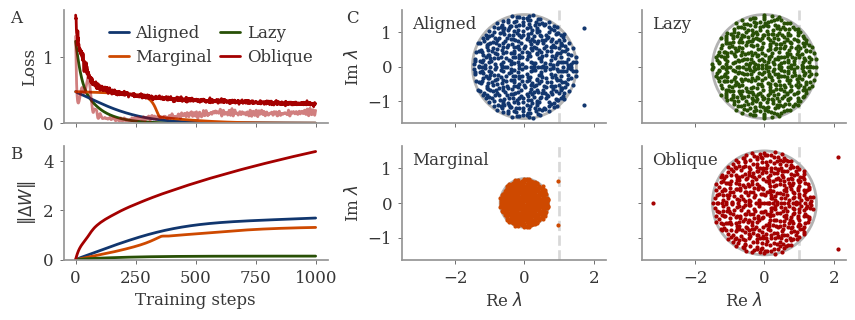

In [25]:
# Loss, |dW|, and spectra after training
n_rows = 2
n_cols = 2
fig = plt.figure(figsize=(8, 2.5))
gs0 = GridSpec(n_rows, 1)
gs0.update(left=0., right=0.33, bottom=0.0, top=1., wspace=0., hspace=0.2)
axes_ldw = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(1)] for k in range(n_rows)])
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0.4, right=1.0, bottom=0.0, top=1., wspace=0.0, hspace=0.2)
axes_ev = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(n_cols)] for k in range(n_rows)])

# Loss, dW
steps = np.arange(n_steps)
rec_steps = np.arange(n_rec_steps)
for i_sce in range(n_sce):
    c = cs[i_sce][0]
    scenario = scenarios[i_sce]
    lbl = scenario.capitalize()
    
    # Loss
    ax = axes_ldw[0, 0]
    ax.plot(steps, loss_sce[i_sce], '-', c=c, label=lbl, zorder=1 if i_sce == 2 else None)
    if scenario == 'oblique':
        ax.plot(rec_steps, loss_nn_sce[i_sce], '-', c=c, alpha=0.5)
        
    # Weight changes
    ax = axes_ldw[1, 0]
    ax.plot(rec_steps, dw_rec_norm_sce[i_sce], c=c)
    
    # EV spectra
    i_c = i_sce // 2
    i_r = i_sce % 2
    ax = axes_ev[i_r, i_c]
    ew = ews_sce[i_sce][1]
    ax.plot(ew.real, ew.imag, 'o', ms=2, c=c, label=lbl)
    ax.text(0.05, 0.95, lbl, ha='left', va='top', transform=ax.transAxes)
    # Radius of eigenvalue circle
    g = g_sce[i_sce]
    circle = plt.Circle((0, 0), g, color=c_leg, fill=False, linewidth=2)
    ax.add_patch(circle)
    
        
# Polish
ax = axes_ldw[0, 0]
# ax.plot(0, 0, '-', c=c_leg, label="Training loss")
# ax.plot(0, 0, '--', c=c_leg, label="Noise-free loss")
leg = ax.legend(loc=1, ncol=2, 
          labelspacing=0.4, handlelength=1.2, handletextpad=0.4, columnspacing=0.5,
          frameon=False,
         )
ax.set_ylim(0, None)
ax.set_ylabel("Loss")
ax.set_xticklabels([])

# Weight changes
ax = axes_ldw[1, 0]
ax.set_ylim(0, None)
ax.set_ylabel(r"$\|\Delta W\|$")
ax.set_xlabel("Training steps")

# EV spectra
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes_ev[i_r, i_c]
    
    ax.axvline(1, ls='--', c=c_leg, zorder=-1, alpha=0.5)
    xmin = ews_sce.real.min() * 1.1
    xmax = ews_sce.real.max() * 1.1
    ymax = ews_sce.imag.max() * 1.1
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-ymax, ymax)
    if i_r ==  n_rows - 1:
        ax.set_xlabel(r"Re $\lambda$")
    else:
        ax.set_xticklabels([])
    if i_c == 0:
        ax.set_ylabel(r"Im $\lambda$")
    else:
        ax.set_yticklabels([])
    ax.set_aspect('equal')
    
# Label plots
for i in range(3):
    if i < 2:
        ax = axes_ldw[i, 0]
        xpos = -0.18
    else:
        ax = axes_ev[i-2, 0]
        xpos = -0.24
    ypos = 1.
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='top', transform=ax.transAxes)

fig.align_ylabels(axes_ldw)
fig_name = "fig_23_sine_overview_loss_ev"
saving_fig(fig, figure_path, fig_name, data_type='both')

# Aligned scenarios

In [46]:
scenarios = ["aligned_decaying", "aligned", "aligned_unstable", "aligned_noisy"]
n_sce = len(scenarios)
res = load_res(scenarios)
[g_sce, out_scale_sce, output_sce, hids_sce, w_out_sce, task_sce, loss_sce, loss_nn_sce, dw_rec_norm_sce, ews_sce,
 h_proj_out_sce, wo_proj_out_sce,
] = res 


Loaded from  ../data/simple_sine_example_aligned_decaying_n_512.pkl
Loaded from  ../data/simple_sine_example_aligned_n_512.pkl
Loaded from  ../data/simple_sine_example_aligned_unstable_n_512.pkl
Loaded from  ../data/simple_sine_example_aligned_noisy_n_512.pkl


Save figure to ../figures/fig_24_sine_aligned.both


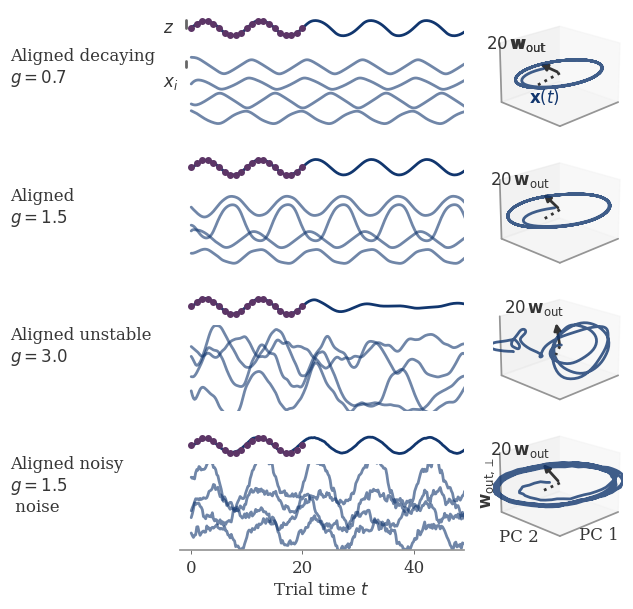

In [47]:
# Summary figure
n_rows = n_sce
n_cols = 1
plt_if = [1]

fig_width = 4.5
fig_height = 1.35 * n_rows
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')

# Output
dy_sce = 0.03
bts = np.linspace(0, 1-(dy_sce*(n_rows-1)), n_rows+1)
bots = (bts[:-1] + np.arange(n_rows) * dy_sce)[::-1]
tops = (1 - bots)[::-1]
axes_out = np.zeros((n_rows, n_cols), dtype=object)
axes_hid = np.zeros((n_rows, n_cols), dtype=object)
for i_r in range(n_rows):
    ohf = 0.7
    doh = tops[i_r] - bots[i_r]
    gs0 = GridSpec(1, n_cols)
    gs0.update(left=0., right=0.63, bottom=bots[i_r] + doh*ohf, top=tops[i_r])
    axes_out[i_r] = [plt.subplot(gs0[0, j]) for j in range(n_cols)]
    gs0 = GridSpec(1, n_cols)
    gs0.update(left=0., right=0.63, bottom=bots[i_r], top=tops[i_r]-doh*(1-ohf))
    axes_hid[i_r] = [plt.subplot(gs0[0, j]) for j in range(n_cols)] 

# PCA
gs0 = GridSpec(n_rows, 1)
gs0.update(left=0.68, right=1.0, bottom=0.0, top=1., wspace=0., hspace=0.05)
axes_pca = np.array([[fig.add_subplot(gs0[k, j], projection='3d')
                      for j in range(1)] for k in range(n_rows)])

for i_r in range(n_rows):
    i_sce = i_r
    scenario = scenarios[i_sce]
    lss = ['-.', '-']
    alphas = [1., 1.]
    cs_if = cs[0][[1, 0]]
    g = g_sce[i_sce]
    task_ev = task_sce[i_sce]
    ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = task_ev
    i_b = 0
    
    ##############################################################################
    # Output and target
    ax = axes_out[i_r, 0]
    for i_ifn in plt_if:
        output = output_sce[i_sce][i_ifn]
        lbl = ["Init", "Final"][i_ifn]
        ax.plot(ts_ev, output, lss[i_ifn], lw=2, c=cs_if[i_ifn], alpha=alphas[i_ifn], label=lbl)
    m = mask_ev[i_b, :, 0]
    ax.plot(ts_ev[m], target_ev[i_b, :, 0][m], 'o', ms=4, c=colors[4], alpha=1.)
    ylim = z_hat * 2.4
    ax.set_ylim(-ylim, ylim)
    if i_r == 0:
        # Plot scale
        ax.plot([-1]*2, [0, 1], '-', lw=2, c='0.4')
    
    ##############################################################################
    # Hidden states
    alpha = 0.6
    max_h_show = 4
    ax = axes_hid[i_r, 0]
    for i_h in range(max_h_show):
        dy = 3
        offset = dy * i_h
        for i_ifn in plt_if:
            ls = ['--', '-'][i_ifn]
            h = hids_sce[i_sce][i_ifn][:, i_h]
            ax.plot(ts_ev, h + offset, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
    if i_r == 0:
        # Plot scale
        ax.plot([-1]*2, np.array([0, 1])+ (max_h_show-1)*dy, '-', lw=2, c='0.4')
    # Insets
    if scenario == 'marginal':
        axins = ax.inset_axes([0.55, 0.05, 0.4, 0.6])
        # x1, x2, y1, y2 = -2, 22, -0.3, 0.3
        ymax_ins = 3/np.sqrt(dim_hid)
        x1, x2, y1, y2 = -2, 22, -ymax_ins, ymax_ins
        i_h = 0 
        for i_ifn in plt_if:
            ls = ['--', '-'][i_ifn]
            h = hids_sce[i_sce][i_ifn][:, i_h]
            axins.plot(ts_ev, h, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.set_yticklabels('')
        axins.set_xticklabels('')
        axins.set_xticks([])
        axins.set_yticks([])
        ax.indicate_inset_zoom(axins, edgecolor="black")
        # Plot scale
        y = 1/np.sqrt(dim_hid)
        axins.plot([-1]*2, [0, y], '-', lw=2, c='0.4')
        axins.text(0, 0, r"$\frac{1}{\sqrt{N}}$", ha='left', va='bottom')
    # yticks
    ymax = (max_h_show-1) * dy
    ax.set_ylim(-0.3 * ymax, 1.4 * ymax)

    ##############################################################################
    # PCA
    alpha = 0.8
    ax = axes_pca[i_r, 0]
    h_proj_plt = h_proj_out_sce
    for i_ifn in plt_if:
        h_proj = h_proj_plt[i_sce, i_ifn]
        ax.plot(*h_proj.T, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
    if i_r == 0:
        ax.text(-1, -1, -30, r"$\mathbf{x}(t)$", ha='right', va='bottom', color=cs_if[i_ifn])
    # Output vectors
    c = '0.2'
    wop = wo_proj_out_sce[i_sce] * 35
    if out_scale_sce[i_sce] == 'small':
        w_fac = 20
        wop *= w_fac
    a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                lw=2, arrowstyle="-|>", color=c)
    a.set_zorder(3)
    ax.add_artist(a)
    # Projection on 2d plane
    ax.plot([0, wop[0]], [0, wop[1]], [0, 0], ':', c=c, lw=2, alpha=1.)
    pos = [
        [wop[0]-7, wop[1], wop[2]+5],
        [wop[0]-7, wop[1], wop[2]],
        [wop[0]-7, wop[1], wop[2]],
        [wop[0]-7, wop[1], wop[2]],
          ][i_sce]
    if i_sce == 0:
        lbl = r"$\mathbf{w}_\mathrm{out}$"
        ax.text(*pos, lbl, ha='right', va='bottom', color=c)
    if out_scale_sce[i_sce] == 'small':
        lbl = r"$%d\, \mathbf{w}_\mathrm{out}$" % w_fac
        ax.text(*pos, lbl, ha='right', va='bottom', color=c)
    # x-axis
    xmax = 25
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-xmax, xmax)
    ax.set_zlim(-xmax, xmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # Perspective
    ax.azim = 45
    # ax.dist = 8
    ax.elev = 20
    if i_r == n_rows-1:
        ax.set_xlabel(r"PC 1", labelpad=-14)
        ax.set_ylabel(r"PC 2", labelpad=-13)
        ax.zaxis.set_rotate_label(False) 
        ax.set_zlabel(r"$\mathbf{w}_{\mathrm{out}, \perp}$", labelpad=-16, rotation=90)
    # Inset
    if scenario == 'marginal':
        rect = [0.05, 0.5, 0.45, 0.45]
        axin = add_inset_axes(rect, units="norm2ax", ax_target=ax, projection="3d")
        axin.plot(*h_proj.T, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
        a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                    lw=2, arrowstyle="-|>", color=c)
        a.set_zorder(3)
        axin.add_artist(a)
        axin.plot([0, wop[0]], [0, wop[1]], [0, 0], ':', c=c, lw=2, alpha=1.)
        xmax = np.abs(h_proj).max()
        # xmax = 1.4
        axin.set_xlim(-xmax, xmax)
        axin.set_ylim(-xmax, xmax)
        axin.set_zlim(-xmax, xmax)
        axin.azim = ax.azim
        # axin.dist = ax.dist
        axin.elev = ax.elev

# Polish output and hidden
for i_r in range(n_rows):
    i_sce = i_r
    for i_ax, ax in enumerate([axes_out[i_r, 0], axes_hid[i_r, 0]]):
        ax.set_yticks([])
        xlim = [-2, 49]
        ax.set_xlim(*xlim)
        xticks = np.array([0, 20, 40])
        ax.set_xticks(xticks)
        # Remove axes
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        if i_ax == 1 and i_sce == n_sce - 1:
            ax.set_xlabel("Trial time $t$")
        else:
            ax.spines["bottom"].set_visible(False)
            ax.xaxis.set_ticks_position('none')
            ax.set_xticks([])
    if i_r == 0:
        xpos = -5
        ax = axes_out[i_r, 0]
        ax.text(xpos, 0, "$z$", fontsize=fs, ha='left', va='center')
        ax = axes_hid[i_r, 0]
        i = max_h_show//2
        lbl = r"$x_i$"
        ax.text(xpos, dy * i, lbl, fontsize=fs, ha='left', va='center')
        

# Regime
for i_r in range(n_rows):
    i_sce = i_r
    scenario = scenarios[i_sce]
    ax = axes_out[i_r, 0]
    g = g_sce[i_sce]
    lbl_f = scenario.capitalize()
    lbl_f = lbl_f.replace("_", " ")
    if len(scenarios) == 3:
        lbl_f += ": "
        lbl_f += "$g = %.1f$" % g
    else:
        lbl_f += "\n"
        lbl_f += [
            r"$g = %.1f$" % g, 
            r"$g = %.1f$" % g, 
            r"$g = %.1f$" % g,
            "$g = %.1f$\n noise" % g, 
        ][i_sce]
    ax.text(-0.6, -0.6, lbl_f, fontsize=fs, ha='left', va='center', transform=ax.transAxes)
    
# Save figure
fig_name = "fig_24_sine_aligned"
saving_fig(fig, figure_path, fig_name, data_type='both')

Save figure to ../figures/fig_25_sine_aligned_loss_ev.both


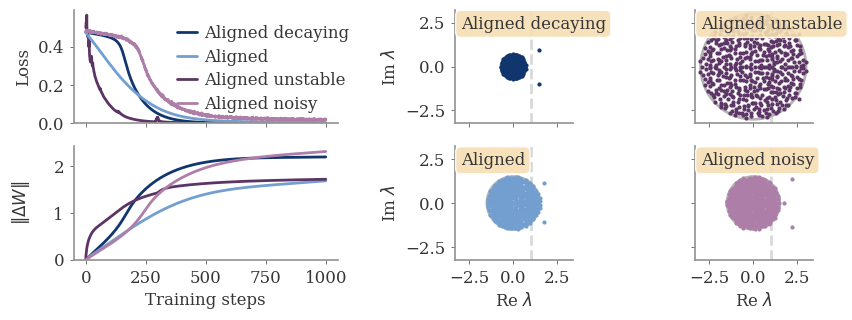

In [48]:
# Loss, |dW|, and spectra after training
n_rows = 2
n_cols = 2
fig = plt.figure(figsize=(8, 2.5))
gs0 = GridSpec(n_rows, 1)
gs0.update(left=0., right=0.33, bottom=0.0, top=1., wspace=0., hspace=0.2)
axes_ldw = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(1)] for k in range(n_rows)])
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0.4, right=1.0, bottom=0.0, top=1., wspace=0.0, hspace=0.2)
axes_ev = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(n_cols)] for k in range(n_rows)])

# Loss, dW
steps = np.arange(n_steps)
rec_steps = np.arange(n_rec_steps)
for i_sce in range(n_sce):
    # c = cs[i_sce][0]
    c = [cs[0][0], cs[0][2], cs[4][0], cs[4][2]][i_sce]
    scenario = scenarios[i_sce]
    lbl = scenario.capitalize()
    lbl = lbl.replace("_", " ")
    
    # Loss
    ax = axes_ldw[0, 0]
    ax.plot(steps, loss_sce[i_sce], '-', c=c, label=lbl, zorder=1 if i_sce == 2 else None)
    if scenario == 'oblique':
        ax.plot(rec_steps, loss_nn_sce[i_sce], '--', c=c, alpha=0.5)
        
    # Weight changes
    ax = axes_ldw[1, 0]
    ax.plot(rec_steps, dw_rec_norm_sce[i_sce], c=c)
    
    # EV spectra
    i_c = i_sce // 2
    i_r = i_sce % 2
    ax = axes_ev[i_r, i_c]
    ew = ews_sce[i_sce][1]
    ax.plot(ew.real, ew.imag, 'o', ms=2, c=c, label=lbl)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    ax.text(0.05, 0.95, lbl, ha='left', va='top', transform=ax.transAxes, bbox=props)
    # Radius of eigenvalue circle
    g = g_sce[i_sce]
    circle = plt.Circle((0, 0), g, color=c_leg, fill=False, linewidth=2)
    ax.add_patch(circle)
    
        
# Polish
ax = axes_ldw[0, 0]
# ax.plot(0, 0, '-', c=c_leg, label="Training loss")
# ax.plot(0, 0, '--', c=c_leg, label="Noise-free loss")
leg = ax.legend(loc=1, ncol=1, 
          labelspacing=0.4, handlelength=1.2, handletextpad=0.4, columnspacing=0.5,
          frameon=False,
          bbox_to_anchor=(1.1, 1),
         )
ax.set_ylim(0, None)
ax.set_ylabel("Loss")
ax.set_xticklabels([])

# Weight changes
ax = axes_ldw[1, 0]
ax.set_ylim(0, None)
ax.set_ylabel(r"$\|\Delta W\|$")
ax.set_xlabel("Training steps")

# EV spectra
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes_ev[i_r, i_c]
    
    ax.axvline(1, ls='--', c=c_leg, zorder=-1, alpha=0.5)
    xmin = ews_sce.real.min() * 1.1
    xmax = ews_sce.real.max() * 1.1
    ymax = ews_sce.imag.max() * 1.1
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-ymax, ymax)
    if i_r ==  n_rows - 1:
        ax.set_xlabel(r"Re $\lambda$")
    else:
        ax.set_xticklabels([])
    if i_c == 0:
        ax.set_ylabel(r"Im $\lambda$")
    else:
        ax.set_yticklabels([])
    ax.set_aspect('equal')
fig.align_ylabels(axes_ldw)

fig_name = "fig_25_sine_aligned_loss_ev"
saving_fig(fig, figure_path, fig_name, data_type='both')

# Oblique scenarios

In [49]:
scenarios = ["oblique_decaying", "oblique", "oblique_unstable", "oblique_input"]
n_sce = len(scenarios)
res = load_res(scenarios)
[g_sce, out_scale_sce, output_sce, hids_sce, w_out_sce, task_sce, loss_sce, loss_nn_sce, dw_rec_norm_sce, ews_sce,
 h_proj_out_sce, wo_proj_out_sce,
] = res 


Loaded from  ../data/simple_sine_example_oblique_decaying_n_512.pkl
Loaded from  ../data/simple_sine_example_oblique_n_512.pkl
Loaded from  ../data/simple_sine_example_oblique_unstable_n_512.pkl
Loaded from  ../data/simple_sine_example_oblique_input_n_512.pkl


Save figure to ../figures/fig_26_sine_oblique.both


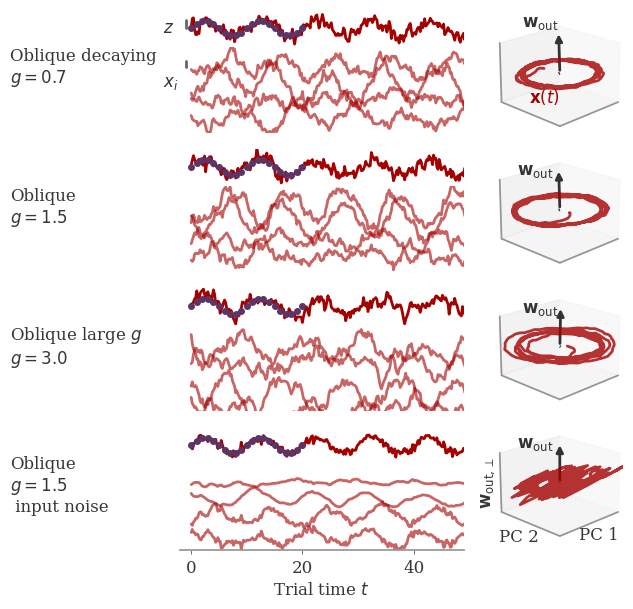

In [50]:
# Summary figure
n_rows = n_sce
n_cols = 1
plt_if = [1]

fig_width = 4.5
fig_height = 1.35 * n_rows
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')

# Output
dy_sce = 0.03
bts = np.linspace(0, 1-(dy_sce*(n_rows-1)), n_rows+1)
bots = (bts[:-1] + np.arange(n_rows) * dy_sce)[::-1]
tops = (1 - bots)[::-1]
axes_out = np.zeros((n_rows, n_cols), dtype=object)
axes_hid = np.zeros((n_rows, n_cols), dtype=object)
for i_r in range(n_rows):
    ohf = 0.7
    doh = tops[i_r] - bots[i_r]
    gs0 = GridSpec(1, n_cols)
    gs0.update(left=0., right=0.63, bottom=bots[i_r] + doh*ohf, top=tops[i_r])
    axes_out[i_r] = [plt.subplot(gs0[0, j]) for j in range(n_cols)]
    gs0 = GridSpec(1, n_cols)
    gs0.update(left=0., right=0.63, bottom=bots[i_r], top=tops[i_r]-doh*(1-ohf))
    axes_hid[i_r] = [plt.subplot(gs0[0, j]) for j in range(n_cols)] 

# PCA
gs0 = GridSpec(n_rows, 1)
gs0.update(left=0.68, right=1.0, bottom=0.0, top=1., wspace=0., hspace=0.05)
axes_pca = np.array([[fig.add_subplot(gs0[k, j], projection='3d')
                      for j in range(1)] for k in range(n_rows)])

for i_r in range(n_rows):
    i_sce = i_r
    scenario = scenarios[i_sce]
    lss = ['-.', '-']
    alphas = [1., 1.]
    cs_if = cs[3][[1, 0]]
    g = g_sce[i_sce]
    task_ev = task_sce[i_sce]
    ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = task_ev
    i_b = 0
    
    ##############################################################################
    # Output and target
    ax = axes_out[i_r, 0]
    for i_ifn in plt_if:
        output = output_sce[i_sce][i_ifn]
        lbl = ["Init", "Final"][i_ifn]
        ax.plot(ts_ev, output, lss[i_ifn], lw=2, c=cs_if[i_ifn], alpha=alphas[i_ifn], label=lbl)
    m = mask_ev[i_b, :, 0]
    ax.plot(ts_ev[m], target_ev[i_b, :, 0][m], 'o', ms=4, c=colors[4], alpha=1.)
    ylim = z_hat * 2.4
    ax.set_ylim(-ylim, ylim)
    if i_r == 0:
        # Plot scale
        ax.plot([-1]*2, [0, 1], '-', lw=2, c='0.4')
    
    ##############################################################################
    # Hidden states
    alpha = 0.6
    max_h_show = 4
    ax = axes_hid[i_r, 0]
    for i_h in range(max_h_show):
        dy = 3
        offset = dy * i_h
        for i_ifn in plt_if:
            ls = ['--', '-'][i_ifn]
            h = hids_sce[i_sce][i_ifn][:, i_h]
            ax.plot(ts_ev, h + offset, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
    if i_r == 0:
        # Plot scale
        ax.plot([-1]*2, np.array([0, 1])+ (max_h_show-1)*dy, '-', lw=2, c='0.4')
    # Insets
    if scenario == 'marginal':
        axins = ax.inset_axes([0.55, 0.05, 0.4, 0.6])
        # x1, x2, y1, y2 = -2, 22, -0.3, 0.3
        ymax_ins = 3/np.sqrt(dim_hid)
        x1, x2, y1, y2 = -2, 22, -ymax_ins, ymax_ins
        i_h = 0 
        for i_ifn in plt_if:
            ls = ['--', '-'][i_ifn]
            h = hids_sce[i_sce][i_ifn][:, i_h]
            axins.plot(ts_ev, h, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.set_yticklabels('')
        axins.set_xticklabels('')
        axins.set_xticks([])
        axins.set_yticks([])
        ax.indicate_inset_zoom(axins, edgecolor="black")
        # Plot scale
        y = 1/np.sqrt(dim_hid)
        axins.plot([-1]*2, [0, y], '-', lw=2, c='0.4')
        axins.text(0, 0, r"$\frac{1}{\sqrt{N}}$", ha='left', va='bottom')
    # yticks
    ymax = (max_h_show-1) * dy
    ax.set_ylim(-0.3 * ymax, 1.4 * ymax)

    ##############################################################################
    # PCA
    alpha = 0.8
    ax = axes_pca[i_r, 0]
    h_proj_plt = h_proj_out_sce
    for i_ifn in plt_if:
        h_proj = h_proj_plt[i_sce, i_ifn]
        ax.plot(*h_proj.T, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
    if i_r == 0:
        ax.text(-1, -1, -30, r"$\mathbf{x}(t)$", ha='right', va='bottom', color=cs_if[i_ifn])
    # Output vectors
    c = '0.2'
    wop = wo_proj_out_sce[i_sce] * 35
    if out_scale_sce[i_sce] == 'small':
        w_fac = 20
        wop *= w_fac
    a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                lw=2, arrowstyle="-|>", color=c)
    a.set_zorder(3)
    ax.add_artist(a)
    # Projection on 2d plane
    ax.plot([0, wop[0]], [0, wop[1]], [0, 0], ':', c=c, lw=2, alpha=1.)
    pos = [
        [wop[0], wop[1], wop[2]],
        [wop[0], wop[1]-4, wop[2]-10],
        [wop[0], wop[1]-2, wop[2]-10],
        [wop[0], wop[1]-5, wop[2]-10],
          ][i_sce]
    # if i_sce == 0:
    lbl = r"$\mathbf{w}_\mathrm{out}$"
    ax.text(*pos, lbl, ha='right', va='bottom', color=c)
    if out_scale_sce[i_sce] == 'small':
        lbl = r"$%d\, \mathbf{w}_\mathrm{out}$" % w_fac
        ax.text(*pos, lbl, ha='right', va='bottom', color=c)
    # x-axis
    xmax = 25
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-xmax, xmax)
    ax.set_zlim(-xmax, xmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # Perspective
    ax.azim = 45
    # ax.dist = 8
    ax.elev = 20
    if i_r == n_rows-1:
        ax.set_xlabel(r"PC 1", labelpad=-14)
        ax.set_ylabel(r"PC 2", labelpad=-13)
        ax.zaxis.set_rotate_label(False) 
        ax.set_zlabel(r"$\mathbf{w}_{\mathrm{out}, \perp}$", labelpad=-16, rotation=90)
    # Inset
    if scenario == 'marginal':
        rect = [0.05, 0.5, 0.45, 0.45]
        axin = add_inset_axes(rect, units="norm2ax", ax_target=ax, projection="3d")
        axin.plot(*h_proj.T, lss[i_ifn], c=cs_if[i_ifn], alpha=alpha)
        a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                    lw=2, arrowstyle="-|>", color=c)
        a.set_zorder(3)
        axin.add_artist(a)
        axin.plot([0, wop[0]], [0, wop[1]], [0, 0], ':', c=c, lw=2, alpha=1.)
        xmax = np.abs(h_proj).max()
        # xmax = 1.4
        axin.set_xlim(-xmax, xmax)
        axin.set_ylim(-xmax, xmax)
        axin.set_zlim(-xmax, xmax)
        axin.azim = ax.azim
        # axin.dist = ax.dist
        axin.elev = ax.elev

# Polish output and hidden
for i_r in range(n_rows):
    i_sce = i_r
    for i_ax, ax in enumerate([axes_out[i_r, 0], axes_hid[i_r, 0]]):
        ax.set_yticks([])
        xlim = [-2, 49]
        ax.set_xlim(*xlim)
        xticks = np.array([0, 20, 40])
        ax.set_xticks(xticks)
        # Remove axes
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        if i_ax == 1 and i_sce == n_sce - 1:
            ax.set_xlabel("Trial time $t$")
        else:
            ax.spines["bottom"].set_visible(False)
            ax.xaxis.set_ticks_position('none')
            ax.set_xticks([])
    if i_r == 0:
        xpos = -5
        ax = axes_out[i_r, 0]
        ax.text(xpos, 0, "$z$", fontsize=fs, ha='left', va='center')
        ax = axes_hid[i_r, 0]
        i = max_h_show//2
        lbl = r"$x_i$"
        ax.text(xpos, dy * i, lbl, fontsize=fs, ha='left', va='center')
        

# Regime
for i_r in range(n_rows):
    i_sce = i_r
    scenario = scenarios[i_sce]
    ax = axes_out[i_r, 0]
    g = g_sce[i_sce]
    lbl_f = scenario.capitalize()
    lbl_f = lbl_f.replace("_", " ")
    if i_sce == 3:
        lbl_f = lbl_f.split(" ")[0]
    if i_sce == 2:
        lbl_f = "Oblique large $g$"
    if len(scenarios) == 3:
        lbl_f += ": "
        lbl_f += "$g = %.1f$" % g
    else:
        lbl_f += "\n"
        lbl_f += [
            r"$g = %.1f$" % g, 
            r"$g = %.1f$" % g, 
            r"$g = %.1f$" % g,
            "$g = %.1f$\n input noise" % g, 
        ][i_sce]
    ax.text(-0.6, -0.6, lbl_f, fontsize=fs, ha='left', va='center', transform=ax.transAxes)
    
# Save figure
fig_name = "fig_26_sine_oblique"
saving_fig(fig, figure_path, fig_name, data_type='both')

Save figure to ../figures/fig_27_sine_oblique_loss_ev.both


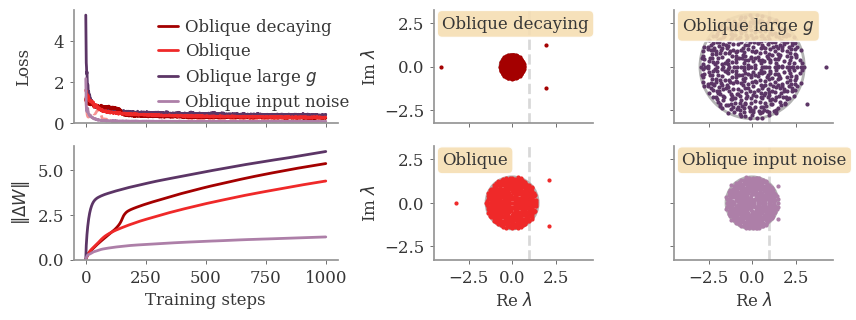

In [52]:
# Loss, |dW|, and spectra after training
n_rows = 2
n_cols = 2
fig = plt.figure(figsize=(8, 2.5))
gs0 = GridSpec(n_rows, 1)
gs0.update(left=0., right=0.33, bottom=0.0, top=1., wspace=0., hspace=0.2)
axes_ldw = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(1)] for k in range(n_rows)])
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0.4, right=1.0, bottom=0.0, top=1., wspace=0.0, hspace=0.2)
axes_ev = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(n_cols)] for k in range(n_rows)])

# Loss, dW
steps = np.arange(n_steps)
rec_steps = np.arange(n_rec_steps)
for i_sce in range(n_sce):
    # c = colors[i_sce]
    c = [cs[3][0], cs[3][2], cs[4][0], cs[4][2]][i_sce]
    scenario = scenarios[i_sce]
    lbl_f = scenario.capitalize()
    lbl_f = lbl_f.replace("_", " ")
    if i_sce == 2:
        lbl_f = "Oblique large $g$"
    if i_sce == 3:
        lbl_f = "Oblique input noise"
    
    # Loss
    ax = axes_ldw[0, 0]
    ax.plot(steps, loss_sce[i_sce], '-', c=c, label=lbl_f, zorder=1 if i_sce == 2 else None)
    if scenario == 'oblique':
        ax.plot(rec_steps, loss_nn_sce[i_sce], '--', c=c, alpha=0.5)
        
    # Weight changes
    ax = axes_ldw[1, 0]
    ax.plot(rec_steps, dw_rec_norm_sce[i_sce], c=c)
    
    # EV spectra
    i_c = i_sce // 2
    i_r = i_sce % 2
    ax = axes_ev[i_r, i_c]
    ew = ews_sce[i_sce][1]
    ax.plot(ew.real, ew.imag, 'o', ms=2, c=c, label=lbl_f)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    ax.text(0.05, 0.95, lbl_f, ha='left', va='top', transform=ax.transAxes, bbox=props)
    # Radius of eigenvalue circle
    g = g_sce[i_sce]
    circle = plt.Circle((0, 0), g, color=c_leg, fill=False, linewidth=2)
    ax.add_patch(circle)
    
        
# Polish
ax = axes_ldw[0, 0]
leg = ax.legend(loc=1, ncol=1, 
          labelspacing=0.4, handlelength=1.2, handletextpad=0.4, columnspacing=0.5,
          frameon=False, bbox_to_anchor=(1.1, 1.05),
         )
ax.set_ylim(0, None)
ax.set_ylabel("Loss")
ax.set_xticklabels([])

# Weight changes
ax = axes_ldw[1, 0]
ax.set_ylim(0, None)
ax.set_ylabel(r"$\|\Delta W\|$")
ax.set_xlabel("Training steps")

# EV spectra
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes_ev[i_r, i_c]
    
    ax.axvline(1, ls='--', c=c_leg, zorder=-1, alpha=0.5)
    xmin = ews_sce.real.min() * 1.1
    xmax = ews_sce.real.max() * 1.1
    ymax = ews_sce.imag.max() * 1.1
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-ymax, ymax)
    if i_r ==  n_rows - 1:
        ax.set_xlabel(r"Re $\lambda$")
    else:
        ax.set_xticklabels([])
    if i_c == 0:
        ax.set_ylabel(r"Im $\lambda$")
    else:
        ax.set_yticklabels([])
    ax.set_aspect('equal')
fig.align_ylabels(axes_ldw)

fig_name = "fig_27_sine_oblique_loss_ev"
saving_fig(fig, figure_path, fig_name, data_type='both')